In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

In [2]:
# Details for nearby tide station
labs = ['M2', 'N2', 'S2', 'K1', 'O1']
amp = [1.572, 0.346, 0.238, 0.141, 0.110] # meters
pha_deg = [306.9, 279.1, 338.0, 118.5, 104.6] # degrees
pha = [p * (np.pi / 180) for p in pha_deg] # rad
spd = [28.984104, 28.43973, 30.0, 15.041069, 13.943035] # deg/hr
T = [360 / s for s in spd] # hr

In [3]:
# Take a piece of the prediction between two peaks
def get_slice(pred, i, peaks, troughs):
    '''
    pred (array)
    i (int) slice number in pred
    peaks (array) indices of peaks
    troughs (array) indices of troughs
    '''
    # Slice predictions around peaks
    sample = pred[peaks[i]:peaks[i+1]]
    
    # Return index of trough relative to sample slice
    if troughs[0] < peaks[0]:
        trough = troughs[i + 1] - peaks[i]
    else:
        trough = troughs[i] - peaks[i]
        
    return sample, trough

def get_start_time(pred, trough, min_head):
    '''
    pred (array) sliced within two peaks
    trough (int) index of trough within slice
    min_head (float) minimum height of water to begin flow
    '''
    # want to find the time when the minimum head is first achieved
    search_range = pred[:trough]

    # Find distance from peak for points in search range
    height_diff = -(search_range - pred[0])

    # Find difference between heights and target head
    head_diff = (abs(height_diff - min_head))

    # Find time where head is closest to min_head
    t_wait = np.where(head_diff == min(head_diff))[0][0]
    
    return t_wait

def get_slope(pred, t_wait):
    '''
    pred (array)
    t_wait (int) index
    '''
#     adjustment = 0.03
    # Slope assumed to be negative
    slope = (pred[t_wait + 1] - pred[t_wait - 1]) / (2)
    slope = slope - slope * 0.5
    return slope

def get_end_time(pred, t_step, t_wait, slope, min_head): 
    # make array of values within range
    t_ = np.linspace(0, len(pred)-1, num = len(pred))
#     print((t_))

    # draw water level across all values in range
    y = slope * (t_ - t_wait) + pred[0]
    
    # find crossing point of internal and external water levels
    cross = np.where(pred0 > y)[0][0]
    
    # constrain search range within t_start and theoretical intersection
    # Offset by three time units to make sure not to find the first point (assumes this is not too many for tide cycle)
    search_range = pred[t_wait + 3:cross]
    search_y = y[t_wait + 3:cross]
    
    # Find distance from peak for points in search range
    height_diff = (search_y - search_range)
    
    # Find difference between heights and target head
    head_diff = (abs(height_diff - min_head))

    # Find time where head is closest to min_head
    t_end_range = np.where(head_diff == min(head_diff))[0][0]
    
    # Account for indices which were previously trimmed
    t_end = t_end_range + t_wait
    
    return t_end

## Simulation

In [15]:
rho = 1025 # [kg/m^3]
A_l = 6.5 * 1000 * 1000 # [m^2]
g = 9.81 # [m/s^2]

# Head required to start allowing flow
min_head = 2 # [m]

# Define how many days to forecast, time intervals
days = 5
t_step = 0.15 # [hr]

start = 0
stop = 24 * days # [hr]

# Time series for forecast
t = np.arange(start = start, stop = stop, step = t_step)

# Make prediction as sum of constituents across time series
pred = 0
for n in range(len(amp)):
    A = amp[n]
    p = pha[n]
    T_ = T[n]
    lab = labs[n]
    pred += A*np.cos(2*np.pi*t/T_ - p)
    
# Find local extrema
peaks, _ = find_peaks(pred)
troughs, _ = find_peaks(-pred)

In [16]:
# Mean height
H_mean = (pred[peaks].sum() - pred[troughs].sum()) / len(peaks)
H_mean

# Potential energy
(1/2 * rho * g * A_l * H_mean**2) / 10**9 # [GJ]

628.5705063421743

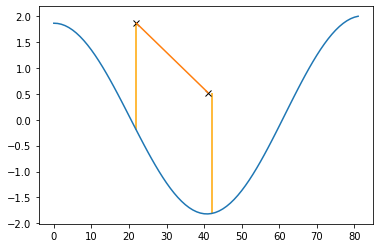

In [24]:
# The length of pred0 is determined by distance between successive peaks, which is variable
pred0, trough0 = get_slice(pred, 7, peaks, troughs)

t_wait = get_start_time(pred0, trough0, min_head)

slope = get_slope(pred0, t_wait)

t_end = get_end_time(pred0, t_step, t_wait, slope, min_head)

t_ = np.arange(t_wait, t_end, 1)
y = slope * (t_ - t_wait) + pred0[0]

plt.plot(pred0)
plt.plot(t_wait, pred0[0], 'kx')
plt.plot(t_[-1], y[-1], 'kx')
plt.vlines(t_wait, pred0[t_wait], y[0], 'orange')
plt.vlines(t_end, pred0[t_end], y[-1], 'orange')
plt.plot(t_, y)
plt.show()

In [36]:
# i = t_wait
hlo = pred0[t_wait:t_end] - y
hdiff = hlo.sum()
E = - rho * A_l * slope * g * hdiff
E / 10**9

-223.32937497933224

In [28]:
len(pred0[t_wait:t_end])

20

In [29]:
len(y)

20